# Data preprocessing

In [74]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/xinyitan/Projects/Challenges/DoorDash')

from pytz import timezone
import pytz

def UTC_to_PST(UTC_datetime):
    return UTC_datetime.replace(tzinfo = pytz.utc).astimezone(tz = 'US/Pacific')

df = pd.read_csv('historical_data.csv', parse_dates = ['created_at', 'actual_delivery_time'])

## Delete unwanted rows with missing target variable and some outliers

1) 7 missing target variable - delivery_duration  
2) 1 outlier sample in 2014

In [67]:
df['delivery_duration_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df_clean = df[(df['delivery_duration_seconds'].notna()) & (df['created_at'].dt.year == 2015)]
print ("Number of observations")
print ("Original data: ", df.shape[0])
print ("Clean data: ", df_clean.shape[0])
df_clean.info()

Number of observations
Original data:  197428
Clean data:  197420
<class 'pandas.core.frame.DataFrame'>
Int64Index: 197420 entries, 0 to 197427
Data columns (total 10 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196433 non-null  float64       
 1   created_at                                    197420 non-null  datetime64[ns]
 2   actual_delivery_time                          197420 non-null  datetime64[ns]
 3   store_id                                      197420 non-null  int64         
 4   subtotal                                      197420 non-null  int64         
 5   total_onshift_dashers                         181159 non-null  float64       
 6   total_busy_dashers                            181159 non-null  float64       
 7   total_outstanding_orders                      181159 non-null  float64 

## Target variable - cap and floor

### Reasoning
1) From EDA, the distribution of target variable "Delivery duration time" have a long right tail; In the problem statement, this model cares "very early/late" more than "slightly early/late". **I'll use MSE as optimiztion metric.** Compared with MAE or RMSE, the training is **more sensitive to outliers**.

2) Purely based on distribution, I decided to **floor and cap the target variable at 10min and 2h**, which would cap ~ 0.5% population. This number can be changed with more reasonable business judgment. 


<AxesSubplot:ylabel='Frequency'>

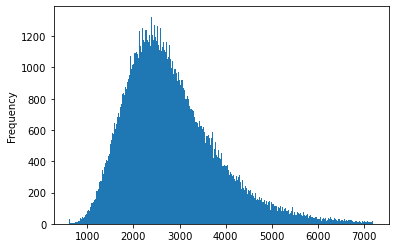

In [63]:
df_clean['duration_cf'] = df_clean['delivery_duration_seconds'].clip(60*10, 60*60*2)
df_clean['duration_cf'].plot.hist(bins = 500)

## Feature engineering


Tree-based models (XGBoost, LightGBM, CatBoost) will be used for this exercise, which needs minimal effort on data cleaning (missing values, outliers) but archieve robust and good models in short time.    

### Categorical variable
1) For existing categorical variables, market_id will be used; and store_id will be igored, considering there're too many stores. Even the top store in the data accounts for less than 0.5% in percentages, which won't provide too much value.

2) Create two new categorical variables to capture time effect: order created day of week and order creaed hour of day

3) Use One-hot encoding to encode three categorical variables

### Continuous variable
1) Create one new continuous variable: total available dashers who are not working on an order

2) Missing values stratgies: impute missing values with median and create missing flags; Three market features share the same missing pattern, which can share one missing flag.

### Feature scaling
Use StandardScaler() to scale all input features

In [124]:
class process_cat_vars(BaseEstimator, TransformerMixin):
            
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def __UTC_to_PST(UTC_datetime):
        return UTC_datetime.replace(tzinfo = pytz.utc).astimezone(tz = 'US/Pacific')
    
    def transform(self, X):

        # time related features
        X['created_PST'] = X['created_at'].apply(UTC_to_PST)
        X['created_day'] = X['created_PST'].dt.weekday
        X['created_hour'] = X['created_PST'].dt.hour
            
        # impute missing market
        X['market'] = X['market_id'].fillna(0).astype(int)
        
        # one-hot encoding
        cat_vars = ['market', 'created_day', 'created_hour']
        enc = OneHotEncoder(sparse = False)
        cat_data = enc.fit_transform(X[cat_vars])
        cat_name = enc.get_feature_names_out(cat_vars)
        return pd.DataFrame(cat_data, columns = cat_name)


class process_num_vars(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # new continuous features
        X['total_notbusy_dashers'] = X['total_onshift_dashers'] - X['total_busy_dashers']
         
        # create missing flags
        X['missing_market_features'] = np.where(X['total_onshift_dashers'].isna(), 1, 0)
        X['missing_driving_estimation'] = np.where(X['estimated_store_to_consumer_driving_duration'].isna(), 1, 0)
        
        # impute missing values with mean
        impute = SimpleImputer(strategy = 'mean')
        imputed_data = impute.fit_transform(X)
        imputed_names = impute.get_feature_names_out(X.columns) 
        return pd.DataFrame(imputed_data, columns = imputed_names)
    
    
cat_vars = ['market_id', 'created_at']
num_vars = ['subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 
            'estimated_store_to_consumer_driving_duration', 'total_notbusy_dashers']

from sklearn.compose import ColumnTransformer
data_pipeline = ColumnTransformer([('cat_pipeline', process_cat_vars(), cat_vars),
                                    ('num_pipeline', process_num_vars(), num_vars) 
                                    ('standardize', StandardScaler(), )
                                  ])

data_processed = data_pipeline.fit_transform(df_clean)
data_names = data_pipeline.get_feature_names_out


In [136]:
data_pipeline.set_params

<bound method ColumnTransformer.set_params of ColumnTransformer(transformers=[('cat_pipeline', process_cat_vars(),
                                 ['market_id', 'created_at']),
                                ('num_pipeline', process_num_vars(),
                                 ['subtotal', 'total_onshift_dashers',
                                  'total_busy_dashers',
                                  'total_outstanding_orders',
                                  'estimated_store_to_consumer_driving_duration',
                                  'total_notbusy_dashers'])])>